# Building the SVM model for classifying PortScanning, DoS TCP and DoS Hulk

## Imports

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
import random

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

In [37]:
scaler = MinMaxScaler()

## Helper Functions

In [38]:
# updated print_confusion_matrix for multi-class classification
def printConfusionMatrix(cm, y_true, normalize=False):
    # get unique class labels
    labels = sorted(set(y_true))

    # visualize the confusion matrix with a heatmap
    plt.figure(figsize=(8, 6))  # set figure size
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


# function to calculate TP, FP, FN, TN for each class
def calculateMetrics(cm):
    """
    Calculate True Positives, False Positives, False Negatives, and True Negatives
    for each class using the confusion matrix.
    """
    metrics = {}
    for classIdx in range(len(cm)):
        tp = cm[classIdx, classIdx]
        fp = cm[:, classIdx].sum() - tp
        fn = cm[classIdx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        metrics[classIdx] = {"TP": tp, "FP": fp, "FN": fn, "TN": tn}
    return metrics


# function to scale specific columns in the data using Standard Scaler
def scaleData(scaler, X_train, X_test, columns_to_scale, fileName = 'standard'):
    # make a copy of the data to avoid modifying the original DataFrame
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # fit and transform the specified columns for X_train
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    # transform only for X_test (using the fit from X_train)
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    joblib.dump(scaler, fileName + '_scaler.pkl')

    # return the scaled dataframes
    return X_train_scaled, X_test_scaled

# function for selecting
def filterBenignValues(dataframe, filterAmount):
    # separate benign rows and non-benign rows
    benign_rows = dataframe[dataframe['Label'] == 'BENIGN']
    non_benign_rows = dataframe[dataframe['Label'] != 'BENIGN']

    # randomly select half of the benign rows
    benign_sample = benign_rows.sample(frac = filterAmount, random_state = 42)  # Adjust random_state for reproducibility

    # combine and return the sampled benign rows with all non-benign rows
    result_df = pd.concat([benign_sample, non_benign_rows])
    return result_df

# function for counting the number of different label types and plotting the result
def count_and_plot(y, labelValues = ['Benign', 'DoS', 'DDoS', 'Port Scanning']):
    # count the number of rows for each label
    labelCounts = y.value_counts().sort_index()

    # calculate additional counts
    countBenign = labelCounts[0] if 0 in labelCounts.index else 0
    countOthers = labelCounts.drop(0).sum() if 0 in labelCounts.index else labelCounts.sum()

    # plot the counts
    plt.figure(figsize=(8, 6))
    plt.bar(labelCounts.index, labelCounts.values, color='skyblue', edgecolor='black')
    plt.xticks(labelCounts.index, labels=[f"{labelValues[lable]}" for lable in labelCounts.index])

    # add labels and show the plot
    plt.xlabel('Label Number')
    plt.ylabel('Number of Rows')
    plt.title(f'Row Counts for Each Label Number\n(Benign: {countBenign}, Others: {countOthers})')
    plt.tight_layout()
    plt.show()

# function for removing null and infi values
def remove_null_and_infi(X_train, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)

    X_train.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)
    X_test.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)

    # ensure no NaN or Inf values remain
    assert not X_train.isnull().any().any(), "X_train still contains NaN values!"
    assert not X_test.isnull().any().any(), "X_test still contains NaN values!"
    assert not (X_train == float('inf')).any().any(), "X_train still contains infinite values!"
    assert not (X_test == float('inf')).any().any(), "X_test still contains infinite values!"

# function for training an SVM model
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, C=1, gamma='scale'):
    # initialize the SVM model with specific C and gamma values
    model = SVC(kernel='rbf', C=C, gamma=gamma) #, class_weight='balanced'
    
    # fit the model
    model.fit(X_train, y_train)

    # predict on the test set
    y_pred = model.predict(X_test)
    
    # calculate train and test accuracy
    trainAccuracy = accuracy_score(y_train, model.predict(X_train))
    testAccuracy = accuracy_score(y_test, y_pred)

    # generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # calculate TP, FP, FN, TN for each class
    metrics = calculateMetrics(cm)

    # generate the classification report
    classReport = classification_report(y_test, y_pred, output_dict=False)

    # print results
    print(f"Train Accuracy: {trainAccuracy:.2f}")
    print(f"Test Accuracy: {testAccuracy:.2f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nMetrics for each class:")
    for classIdx, values in metrics.items():
        print(f"Class {classIdx} -> TP: {values['TP']}, FP: {values['FP']}, FN: {values['FN']}, TN: {values['TN']}")

    print("\nClassification Report:")
    print(classReport)

    # visualize the confusion matrix
    printConfusionMatrix(cm, y_test)

    return model

## Import Attack Datasets

In [39]:
# import the attack sample dataset
dosSamples1 = pd.read_csv('dos_dataset_updated_flows.csv')
dosSamples1.head(3)

,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
0,1,0,0,0,0,0,0,0,0,0,...,11143,0,0,0.210407,52350.008012,0.203293,0.004944,0.000017,0.000116,DoS
1,1,0,0,0,0,0,0,0,0,0,...,2652,0,0,0.034620,14056.721642,0.047585,0.001158,0.000004,0.000028,DoS
2,1,0,0,0,0,0,0,0,0,0,...,2761,0,0,0.035557,12047.220322,0.050298,0.001092,0.000004,0.000041,DoS


In [40]:
# import the attack sample dataset
dosSamples2 = pd.read_csv('dos_hulk_dataset_updated_flows.csv')
dosSamples2.head(3)

,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
0,1,43.719346,0,540.854225,43.719346,131.721389,11870.560064,383505.355773,540.854225,43.719346,...,4579,5249.0,2211.0,37.769779,277.492885,37.769779,14.626067,0.004611,0.082211,DoS
1,1,37.072393,0,429.572400,37.072393,84.741981,10297.168947,328610.926963,429.572400,37.072393,...,5429,6478.0,1958.0,10.917602,999.799786,10.917602,5.543607,0.001362,0.021129,DoS
2,1,60.500871,0,385.000121,60.500871,108.243354,10358.786904,403843.880448,385.000121,60.500871,...,5883,7183.0,1995.0,11.879885,925.070588,11.879885,4.613893,0.001545,0.015653,DoS


In [41]:
# import the attack sample dataset
portSamples1 = pd.read_csv('port_scan_dataset_updated_flows.csv')
portSamples1.head(3)

,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
0,971,0,0,0,0,0,0,0,0,0,...,1967,0,0,29.353887,54.215647,28.470199,0.875155,0.012156,0.043229,PortScan
1,504,0,0,0,0,0,0,0,0,0,...,989,0,0,14.797953,27.220348,14.749746,0.453649,0.006268,0.023172,PortScan
2,792,0,0,0,0,0,0,0,0,0,...,1558,0,0,23.230515,43.897096,23.994685,0.687232,0.009857,0.036453,PortScan


In [42]:
# import the attack sample dataset
portSamples2 = pd.read_csv('port_scan_dataset_updated_flows_open_ports.csv')
portSamples2.head(3)

,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
0,3066,0,0,0,0,0,0,0,0,0,...,6213,10,10,11.611609,323.075192,11.931991,0.713778,0.001216,0.013480,PortScan
1,3988,0,0,0,0,0,0,0,0,0,...,8069,14,14,15.512145,429.144158,15.503727,0.960733,0.001570,0.017592,PortScan
2,3714,0,0,0,0,0,0,0,0,0,...,7564,13,13,13.986972,400.895137,14.021729,0.867224,0.001465,0.016378,PortScan


In [43]:
# merge the port attack datasets
mergedPortDataset = pd.concat([portSamples1, portSamples2], axis=0)
mergedPortDataset = mergedPortDataset.sample(frac=1, random_state=42).reset_index(drop=True)
mergedPortDataset = mergedPortDataset.sample(n=17000, random_state = 42) 
print(mergedPortDataset.shape)

(17000, 27)


In [44]:
# sample dos attack dataset
mergedDosDataset = pd.concat([dosSamples1, dosSamples2], axis=0)
mergedDosDataset = mergedDosDataset.sample(frac=1, random_state=42).reset_index(drop=True)
mergedDosDataset = mergedDosDataset.sample(n=17000, random_state = 42) 
print(mergedDosDataset.shape)

(17000, 27)


In [45]:
# merge the attack datasets
mergedPortDosDataset = pd.concat([mergedPortDataset, mergedDosDataset], axis=0)
mergedPortDosDataset = mergedPortDosDataset.sample(frac=1, random_state=42).reset_index(drop=True)
mergedPortDosDataset.tail(3)

,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
33997,2852,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5756,9.0,10.0,10.722515,300.555419,11.116636,0.683638,0.001131,0.012555,PortScan
33998,553,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1119,0.0,0.0,16.651790,30.666548,16.219220,0.482391,0.006905,0.024691,PortScan
33999,5278,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10434,18.0,18.0,20.520685,568.921764,19.842512,1.231130,0.002036,0.023262,PortScan


## Import Benign Dataset

In [46]:
# import the bening datasets
benign1 = pd.read_csv('full_benign.csv')
benign5 = pd.read_csv('benign_dataset_5.csv')
benign6 = pd.read_csv('benign_dataset_6.csv')

In [47]:
# merge the benign
mergedBenign = pd.concat([benign1, benign5, benign6], axis=0)
mergedBenign = mergedBenign.sample(frac=1, random_state=42).reset_index(drop=True)

# adding a label to the dataset
mergedBenign['Label'] = 'BENIGN'

print(mergedBenign.shape)
mergedBenign.tail(3)

(49161, 27)


,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
49158,0,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,30.015820,0.099947,30.015820,15.008803,15.007910,0.000893,BENIGN
49159,6,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,10.980657,1.092831,10.980657,10.948638,0.998242,3.146594,BENIGN
49160,1,0.0,0,0,0.0,0.0,0.0,0.0,0,0.0,...,0,0,0,30.072302,0.399038,30.072302,15.525795,2.733846,5.796891,BENIGN


In [48]:
# check for duplicates in the subset of selected features
duplicatesMask = mergedBenign.duplicated(keep='first')
numDuplicates = duplicatesMask.sum()
print(f"Number of duplicate rows based on selected features: {numDuplicates}")

# remove duplicates directly
mergedBenign = mergedBenign.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedBenign.shape}")

Number of duplicate rows based on selected features: 1418
Shape of dataset after removing duplicates: (47743, 27)


In [49]:
mergedBenign.head(5)

,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
0,1,0.0,0,0,0.0,0.000000,0.00,0.0,0,0.0,...,0,0,0,30.018951,0.099937,30.018951,15.013037,15.009475,0.003561,BENIGN
1,1,364.6,318,398,364.6,29.530323,872.04,3646.0,398,364.6,...,0,0,0,0.089526,111.699472,0.089526,0.010255,0.009947,0.000207,BENIGN
2,1,0.0,0,0,0.0,0.000000,0.00,0.0,0,0.0,...,0,0,0,30.090522,0.398797,30.090522,15.540874,2.735502,5.799413,BENIGN
3,1,0.0,0,0,0.0,0.000000,0.00,0.0,0,0.0,...,0,0,0,1.004944,1.990160,1.004944,1.004944,1.004944,0.000000,BENIGN
4,1,0.0,0,0,0.0,0.000000,0.00,0.0,0,0.0,...,0,0,0,30.091528,0.398783,30.091528,15.527713,2.735593,5.801400,BENIGN


In [50]:
# mergedBenign.to_csv('full_benign_2.csv', index=False)

## Merging Benign With Attack

In [51]:
# merge the benign
mergedDataset = pd.concat([mergedPortDosDataset, mergedBenign], axis=0)
mergedDataset = mergedDataset.sample(frac=1, random_state=42).reset_index(drop=True)

print(mergedDataset.shape)
mergedDataset.tail(3)

(81743, 27)


,Number of Ports,Average Packet Size,Packet Length Min,Packet Length Max,Packet Length Mean,Packet Length Std,Packet Length Variance,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,...,SYN Flag Count,ACK Flag Count,RST Flag Count,Flow Duration,Packets Per Second,IAT Total,IAT Max,IAT Mean,IAT Std,Label
81740,2,37.6,31,46.0,37.6,5.388877,29.04,125.0,32.0,31.25,...,0,0.0,0.0,40.147377,0.249082,40.147377,17.545420,4.460820,7.053627,BENIGN
81741,1697,0.0,0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,...,3341,0.0,0.0,49.741132,94.889598,49.596309,1.477985,0.021049,0.075635,PortScan
81742,1,0.0,0,0.0,0.0,0.000000,0.00,0.0,0.0,0.00,...,3974,0.0,0.0,0.055054,37059.441094,0.056180,0.001971,0.000006,0.000060,DoS


## Building The Model

(57220, 26) (24523, 26) (57220,) (24523,)


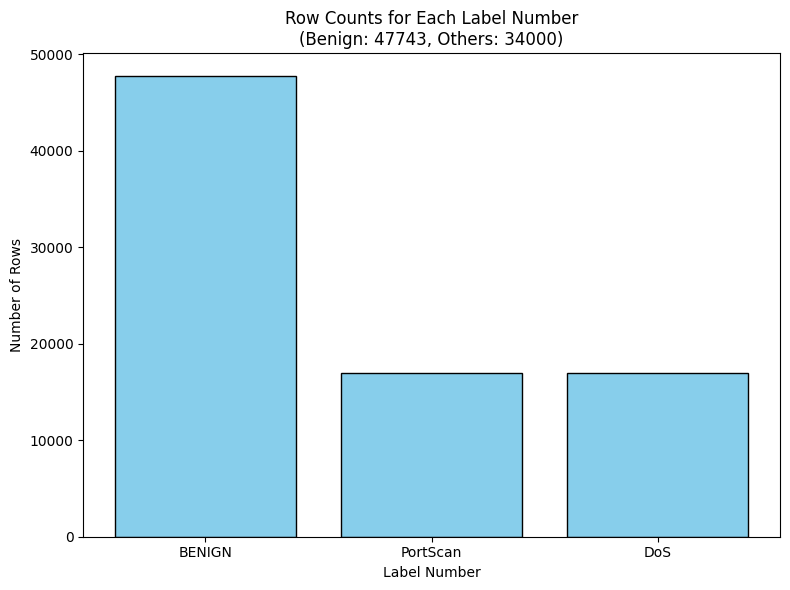

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[14239     0     0]
 [    0  5123     0]
 [    0     0  5161]]

Metrics for each class:
Class 0 -> TP: 14239, FP: 0, FN: 0, TN: 10284
Class 1 -> TP: 5123, FP: 0, FN: 0, TN: 19400
Class 2 -> TP: 5161, FP: 0, FN: 0, TN: 19362

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     14239
           1       1.00      1.00      1.00      5123
           2       1.00      1.00      1.00      5161

    accuracy                           1.00     24523
   macro avg       1.00      1.00      1.00     24523
weighted avg       1.00      1.00      1.00     24523



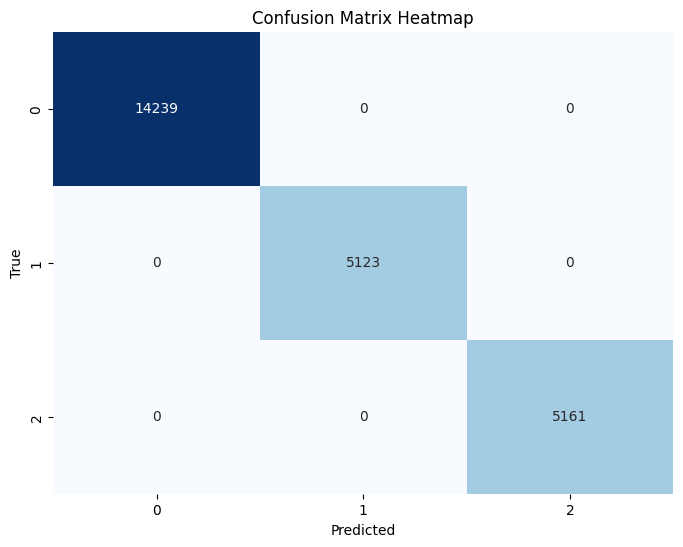

Runtime: 0.04 minutes
Model saved successfully!


In [52]:
# train-test split
X = mergedDataset.drop(columns=['Label'])
y = mergedDataset['Label']

mappingLabels = {
    'BENIGN': 0, 
    'PortScan': 1,
    'DoS': 2
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'PortScan', 'DoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale, 'new_flows_port_dos_hulk')

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'new_flows_port_dos_hulk_svm_model.pkl')  
print("Model saved successfully!")

In [53]:
# mergedDataset.to_csv('port_scan_dos_hulk_dataset_updated_flows_FULL.csv', index=False)